In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
#import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, pearsonr
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

In [2]:
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'light'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

act_directory = '/Users/insanallylab/Documents/Sharadhi_PNC_Rotation/Notebooks/Analysis_Cache'
#ops_directory = 'C:\\Users\insan\\Desktop\\Opsin_Cache'
beh_directory = '/Users/insanallylab/Desktop/Behavioor'

#opsin
did_learn_animals = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn_animals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate_animals = ['BS_139','BS_165','BS_191','BS_192']
all_opsin_animals = np.concatenate((did_learn_animals,did_not_learn_animals,indeterminate_animals))

#Ephy
ephys_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

/Users/insanallylab/Desktop/EphysAnalysis/Notebooks/SB/../../InsanallyLabEphysTools/behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite valu

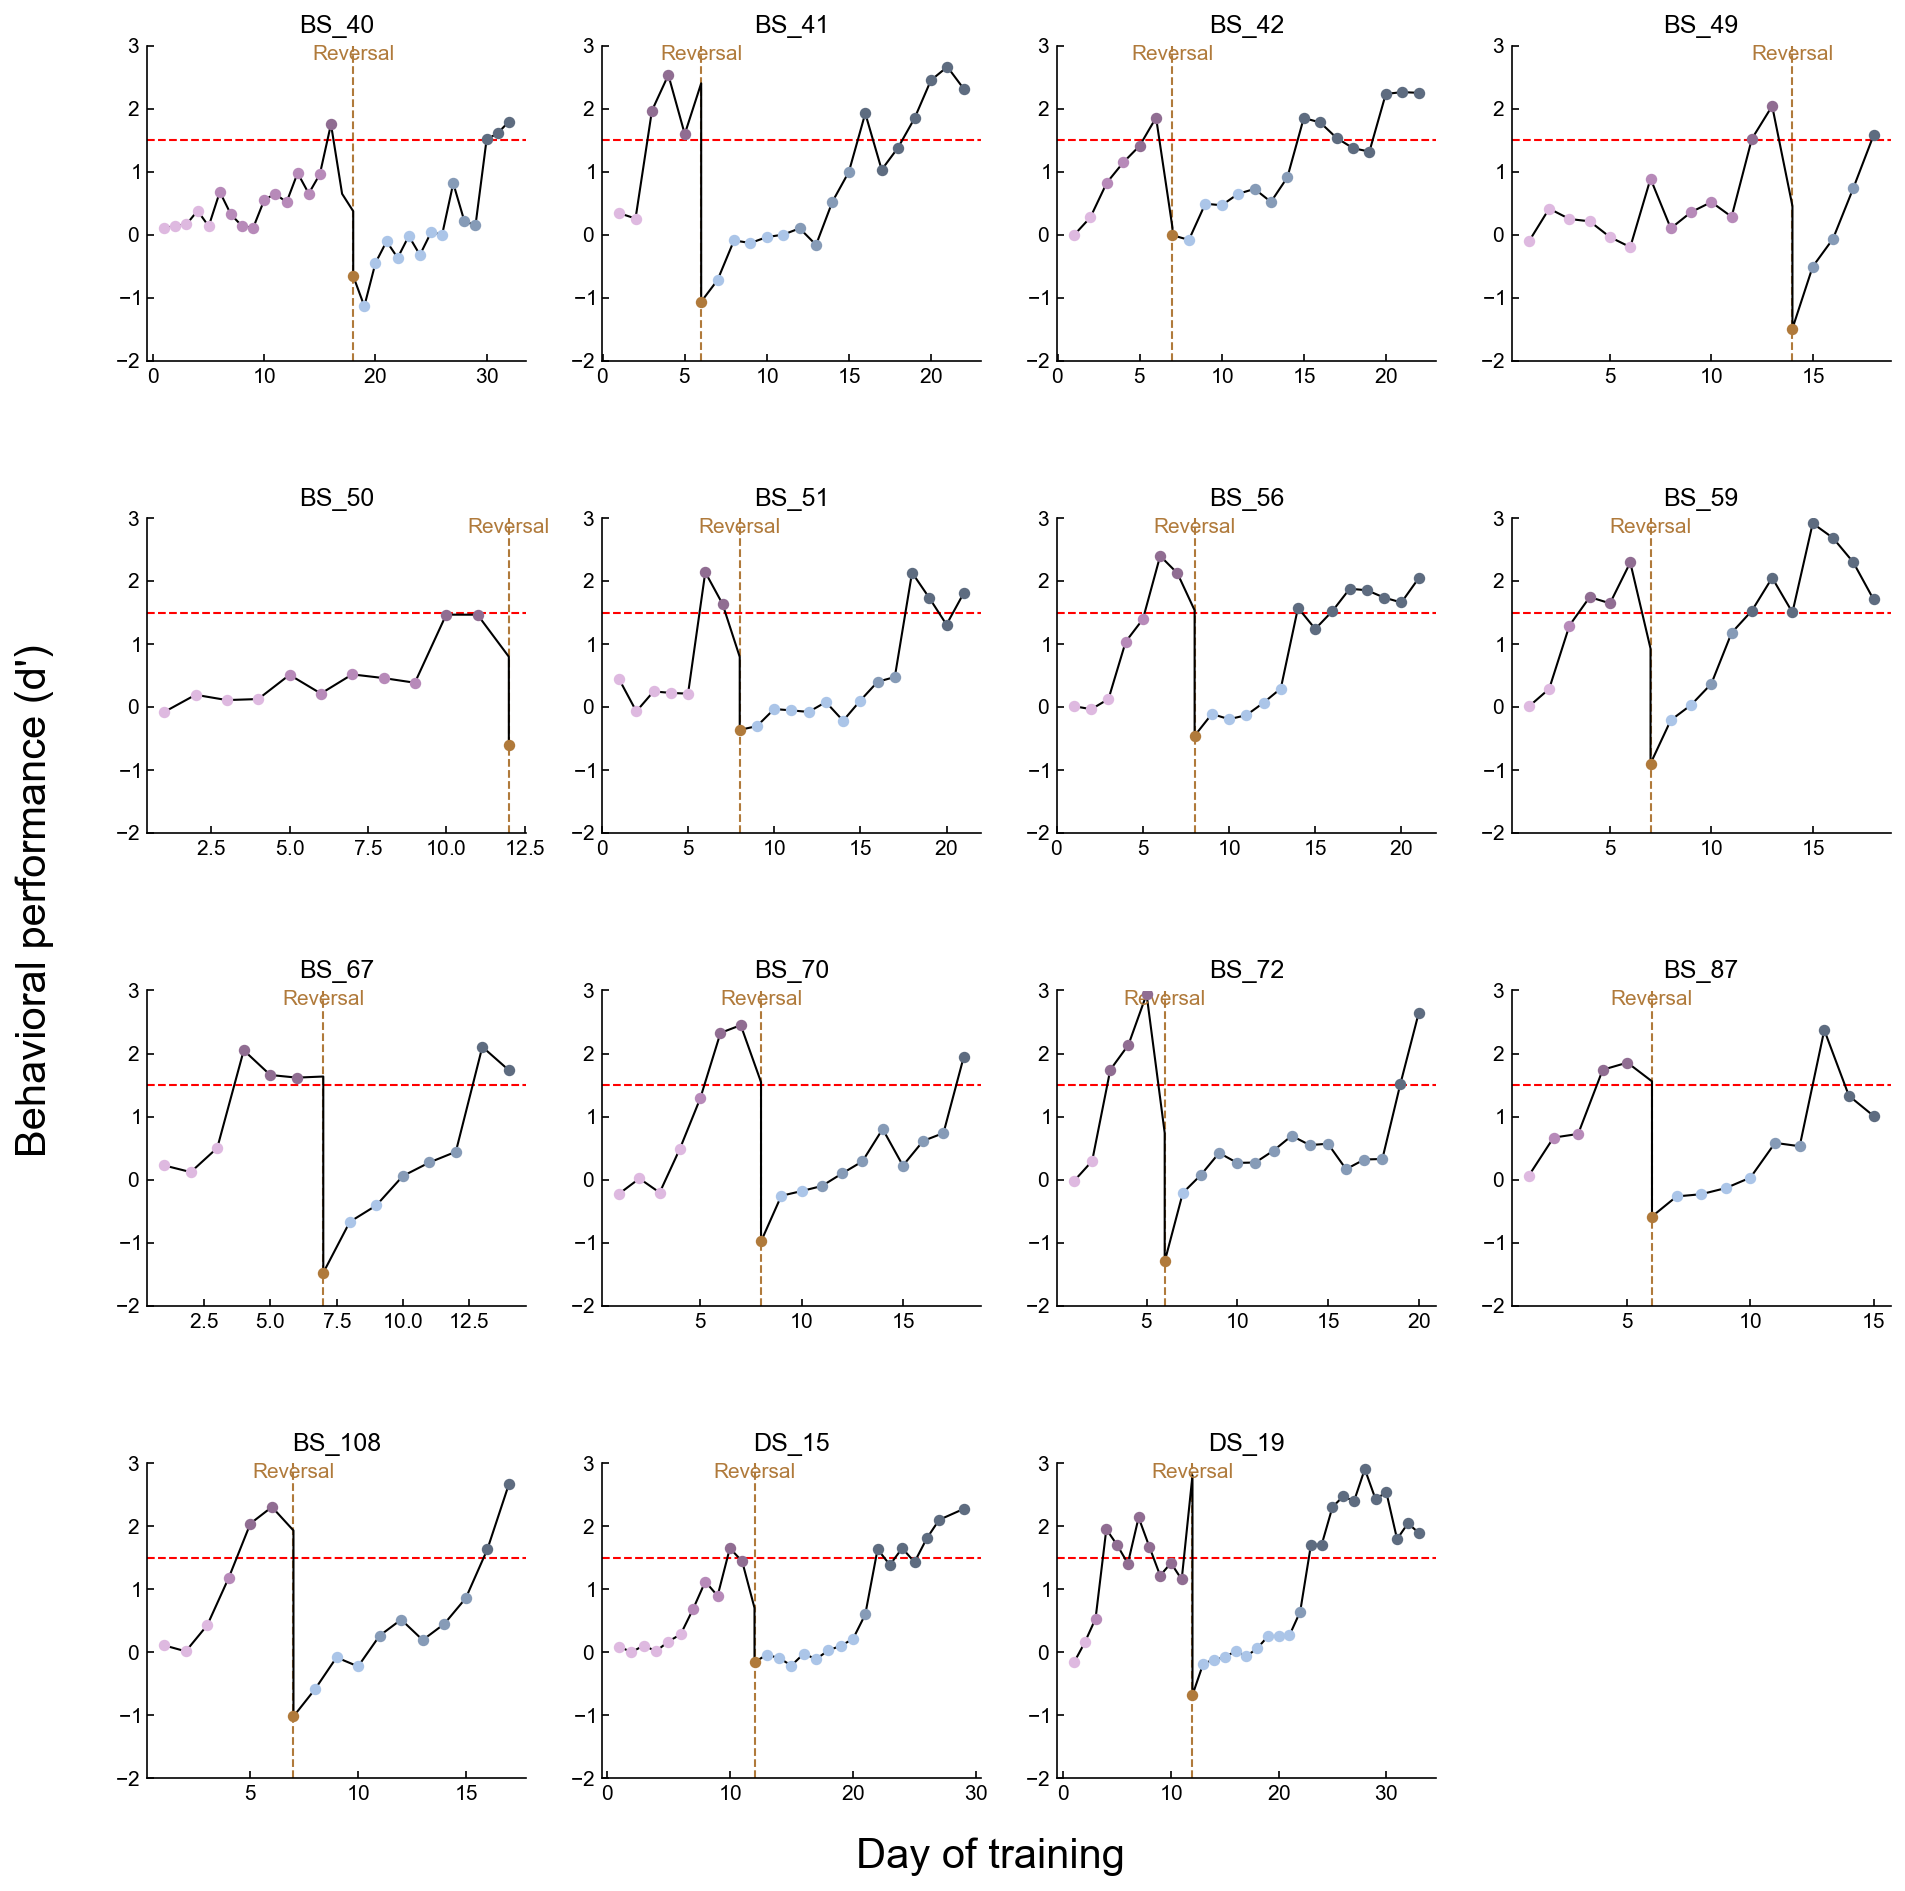

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(ephys_animals,animalBehaviors,plot=True)

In [5]:
EnumACSession = []
EnumACClust = []
EnumM2Session = []
EnumM2Clust = []

sessions = os.listdir(act_directory)

numAC = 0
numM2 = 0

for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.task in ['opto nonreversal','opto switch','opto reversal']:
        continue
    if sessionfile.meta.task in ['opto control nonreversal','opto control switch','opto control reversal']:
        continue
    
    if sessionfile.meta.animal not in ephys_animals:
        continue
    
    #attribute neurons based on the region
    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumACSession.append(session)
            EnumACClust.append(clust)
            
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumM2Session.append(session)
            EnumM2Clust.append(clust)    
    else:
        pass

        
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))

100%|█████████████████████████████████████████| 255/255 [00:13<00:00, 19.51it/s]

AC       : 1832
M2       : 1628


In [6]:
EILM2phases = np.full_like(EnumM2Session,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumM2Session)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILM2phases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILM2phases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILM2phases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILM2phases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILM2phases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILM2phases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILM2phases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|███████████████████████████████████████| 1628/1628 [00:31<00:00, 51.80it/s]

errors for: []


In [7]:
EILACphases = np.full_like(EnumACSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumACSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILACphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILACphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILACphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILACphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILACphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILACphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILACphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|███████████████████████████████████████| 1832/1832 [00:43<00:00, 41.78it/s]

errors for: []


In [10]:
session_1_AC = ilep.loadSessionCached(act_directory,EnumACSession[0])
session_1_M2 = ilep.loadSessionCached(act_directory,EnumM2Session[625])
clust_AC = session_1_AC.clusters.good
clust_M2 = session_1_M2.clusters.good

In [22]:
trials_AC = ilep.getAllConditions(session_1_AC,clust_AC[0],trialsPerDayLoaded=None)['all_trials']
trials_M2 = ilep.getAllConditions(session_1_M2,clust_M2[0],trialsPerDayLoaded=None)['all_trials']

In [27]:
start_trials_AC = session_1_AC.trials.starts
start_trials_M2 = session_1_M2.trials.starts

In [31]:
type(trials_AC)

types.SimpleNamespace

In [24]:
EnumM2Session.index('BS_70_1_M2.pickle')

625

In [25]:
session_1_AC = ilep.loadSessionCached(act_directory,EnumACSession[0])
session_1_M2 = ilep.loadSessionCached(act_directory,EnumM2Session[625])

In [26]:
start_trials_AC = session_1_AC.trials.starts
start_trials_M2 = session_1_M2.trials.starts

In [27]:
len(start_trials_M2)

545

In [28]:
clust_AC = session_1_AC.clusters.good
clust_M2 = session_1_M2.clusters.good

In [59]:
spikeTimes_AC = [[]]
spikeTimes_M2 = [[]]
for i in range (len(start_trials_M2)):
    end_time = start_trials_AC[i] + 0.2*30000
    spikeTimes_1_AC = ilep.getSpikeTimes(session_1_AC,clust=clust_AC[0],starttime=start_trials_M2[i],endtime=end_time,cachedtimes=None)
    spikeTimes_1_M2 = ilep.getSpikeTimes(session_1_M2,clust=clust_M2[0],starttime=start_trials_M2[i],endtime=end_time,cachedtimes=None)
    spikeTimes_AC.append(spikeTimes_1_AC)
    spikeTimes_M2.append(spikeTimes_1_M2)

In [76]:
spikeCountsAC = []
spikeCountsM2 = []

spikeCountsAC = [len(row) for row in spikeTimes_AC]
#spikeCountsACnp = np.reshape(spikeCountsAC, (1, len(spikeCountsAC)))
spikeCountsM2 = [len(row2) for row2 in spikeTimes_M2]
#spikeCountsM2np = np.reshape(spikeCountsM2, (1, len(spikeCountsM2)))

In [80]:
sumAC = sum(spikeCountsAC)
sumM2 = sum(spikeCountsM2)
avgAC = sumAC/len(spikeCountsAC)
avgM2 = sumM2/len(spikeCountsM2)

resSpikeCountAC = []
resSpikeCountM2 = []

for i in range (len(spikeCountsAC)):
    resSCAC = spikeCountsAC[i] - avgAC
    resSCM2 = spikeCountsM2[i] - avgM2
    resSpikeCountAC.append(resSCAC)
    resSpikeCountM2.append(resSCM2)

In [83]:
corrcoeff, p_value = pearsonr(resSpikeCountAC, resSpikeCountM2)

In [ ]:
#only include names starting with BS and exclude DS
#

In [9]:
[k for k in animalBehaviors['BS_50'].sessions]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [11]:
animalBehaviors['BS_50'].reversal

inf

In [12]:
animalBehaviors['BS_50'].sessions[12]

namespace(animal='BS_50',
          session=12,
          files=array(['BS_50_12v1_reversal.txt', 'BS_50_12v1.txt',
                       'BS_50_12v3_reversal.txt', 'BS_50_12v4_reversal.txt'], dtype='<U23'),
          blocknumbers=array([1, 1, 3, 4]),
          type='switch',
          trials_per_session=array([ 29., 200.,  29.,  82.]),
          outcomes=0     1
                   1     1
                   2     1
                   3     1
                   4     2
                        ..
                   77    2
                   78    2
                   79    4
                   80    2
                   81    2
                   Name: outcome, Length: 340, dtype: int64,
          response_time=0     0.45717
                        1     0.31026
                        2     0.98948
                        3     0.31212
                        4     2.50150
                               ...   
                        77    2.50030
                        78    2.5003